In [1]:
from sklearn.dummy import DummyClassifier
import pandas as pd
import numpy as np
import xgboost as xgb

# from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (
    Normalizer,
    FunctionTransformer,
    RobustScaler,
    LabelEncoder,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedShuffleSplit
from sklearn.feature_selection import (
    SelectFromModel,
    VarianceThreshold,
    chi2,
    SelectKBest,
    mutual_info_classif,
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, shapiro, probplot, ks_2samp
import category_encoders as ce
from catboost import CatBoostClassifier
from sklearn.tree import export_graphviz
from boruta import BorutaPy
from dython.model_utils import random_forest_feature_importance

/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_featurized.parquet.gzip"
)
test_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_featurized.parquet.gzip"
)

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/chrome/08_12_2022/train_set_01_featurized.parquet.gzip'

In [49]:
train_data

,content-type,accept-ranges,etag,vary,content-encoding,cache-control,expires,content-length,server,age,...,etag_length,access-control-allow-origin_cumulative,pragma_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,strict-transport-security_binary,access-control-allow-credentials_binary,timing-allow-origin_binary,tracker
0,text/javascript; charset=utf-8,Missing,15601544113783900868,accept-encoding,gzip,"public, max-age=1209600","fri, 26 aug 2022 11:22:22 gmt",13475,cafe,5806.0,...,20,Missing,0,1,1,1,0,0,1,1
1,application/javascript,bytes,0x8da7b64a03a8ae5,accept-encoding,gzip,max-age=630720000,"thu, 31 dec 2037 23:55:55 gmt",4768,nginx,90752.0,...,-1,*,0,0,0,1,1,0,1,0
2,image/gif,Missing,Missing,accept-encoding,gzip,"no-cache, no-store, must-revalidate","fri, 01 jan 1990 00:00:00 gmt",42,cafe,-1.0,...,-1,Missing,1,1,1,1,0,0,1,1
3,image/jpeg,bytes,0x8da7b64a03a8ae5,accept-encoding,gzip,no-store,"thu, 31 dec 2037 23:55:55 gmt",0,nginx,90752.0,...,-1,*,1,0,0,0,0,0,1,0
4,text/html; charset=utf-8,bytes,0x8da7b64a03a8ae5,accept-encoding,gzip,"private, max-age=0","sun, 01 feb 1970 00:00:00 gmt",7461,nginx,90752.0,...,-1,Missing,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271999,image/png,bytes,"""618df712-2509""",accept-encoding,gzip,max-age=31622400,"thu, 03 aug 2023 14:44:48 gmt",9481,nginx,845572.0,...,15,Missing,0,0,0,0,1,0,0,0
272000,image/gif,Missing,Missing,accept-encoding,gzip,"no-store, no-cache, must-revalidate, max-age=0","mon, 04 dec 1999 21:29:02 gmt",49,cafe,-1.0,...,-1,*,1,0,0,1,0,0,1,1
272001,binary/octet-stream,bytes,"""4abfa4888190370d347034f9fa43c804""","accept-encoding,origin",gzip,max-age=31536000,"thu, 31 dec 2037 23:55:55 gmt",57064,amazons3,709890.0,...,34,Other,0,0,0,0,0,1,0,0
272002,application/xml,bytes,"""29a-1630333f5d8""","x-edge-forwarded-proto, x-forwarded-host, acce...",gzip,"public, max-age=86400","thu, 31 dec 2037 23:55:55 gmt",666,nginx,28523.0,...,17,Missing,0,0,1,1,1,0,0,0


In [3]:
train_data.drop(train_data[train_data.age < -2].index, inplace=True)
test_data.drop(test_data[test_data.age < -2].index, inplace=True)

TypeError: Unordered Categoricals can only compare equality or not

In [13]:
train_data = pd.read_parquet(
        "../data/processed/chrome/08_12_2022/train_set_01_processed.parquet.gzip"
    )
test_data = pd.read_parquet(
    "../data/processed/firefox/08_12_2022/test_set_01_processed.parquet.gzip"
    )

# exclude metadata columns
train_data = train_data.iloc[:, 4:]
test_data = test_data.iloc[:, 4:]

In [17]:
for elem in train_data.iloc[:, :-4].columns.values.tolist():
    train_data[f"{elem}_binary"] = np.where(train_data[elem].isnull(), 0, 1)
    test_data[f"{elem}_binary"] = np.where(test_data[elem].isnull(), 0, 1)

# for df in [train_data, test_data]:
#     df.drop(train_data.columns.values.tolist(), axis=1, inplace=True)

<ipython-input-17-a06f78be8e29>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[f"{elem}_binary"] = np.where(train_data[elem].isnull(), 0, 1)
<ipython-input-17-a06f78be8e29>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[f"{elem}_binary"] = np.where(test_data[elem].isnull(), 0, 1)
<ipython-input-17-a06f78be8e29>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

In [18]:
cols = train_data.iloc[:, :150].columns.values.tolist()

In [19]:
for df in [train_data, test_data]:
    df.drop(cols, axis=1, inplace=True)

In [5]:
train_data = train_data.iloc[:, :-4]
test_data = test_data.iloc[:, :-4]

In [14]:
train_data.drop('header_count', axis=1, inplace=True)

In [22]:
def label_as_last_column(dataset):
    temp_cols = dataset.columns.tolist()
    index_col = dataset.columns.get_loc("tracker")
    new_col_order = (
        temp_cols[0:index_col]
        + temp_cols[index_col + 1:]
        + temp_cols[index_col: index_col + 1]
    )
    return new_col_order


reordered_cols = label_as_last_column(train_data)
train_data = train_data[reordered_cols]
test_data = test_data[reordered_cols]

In [192]:
train_data.loc[train_data.age < 0, ["age", "tracker"]].value_counts()

age    tracker
-1.0   1          62554
-16.0  0              2
-81.0  0              1
-64.0  0              1
dtype: int64

In [8]:
train_data[["tracker", "accept-ranges"]].value_counts()

tracker  accept-ranges
0        bytes            194292
1        Missing           62200
         bytes             15025
0        none                393
1        none                 94
dtype: int64

In [172]:
train_data[["tracker", "vary"]].value_counts()

tracker  vary                                                       
0        accept-encoding                                                42310
1        accept-encoding                                                18000
0        origin                                                          1594
         accept                                                          1490
1        origin                                                           989
                                                                        ...  
0        partnerpage-origin                                                 1
         referer,x-forwarded-proto                                          1
         accept-encoding, treat-as-untrusted, cookie                        1
         accept-encoding,x-tenant-id, x-country-code, x-profile-type        1
         accept-encoding, show-do-not-sell-link, platform, x-options        1
Length: 365, dtype: int64

In [17]:
train_data[["content-type"]].value_counts()

content-type                                                          
image/jpeg                                                                34160
application/javascript                                                    31358
image/gif                                                                 27280
image/png                                                                 24171
application/javascript; charset=utf-8                                     17084
                                                                          ...  
application/vnd.rbgemc+json; charset=utf-8                                    1
application/vnd.seznam-cz.spl+json                                            1
text/html; charset=iso-8859-15                                                1
image/jpeg; name=resize_7910cde8-8a03-4eb2-acfa-dff187bbe56c335079.jpg        1
image/jpeg; name=ecu.jpg                                                      1
Length: 323, dtype: int64

In [43]:
from dython.nominal import identify_numeric_columns, identify_nominal_columns

In [27]:
variance = VarianceThreshold(threshold=0.5)
a = variance.fit_transform(train_data[identify_numeric_columns(train_data)])

In [29]:
train_data[identify_numeric_columns(train_data)]

,content-length,age,pragma_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,strict-transport-security_binary,access-control-allow-credentials_binary,timing-allow-origin_binary
0,13475,5806.0,0,1,1,1,0,0,1
1,4768,90752.0,0,0,0,1,1,0,1
2,42,-1.0,1,1,1,1,0,0,1
3,0,90752.0,1,0,0,0,0,0,1
4,7461,90752.0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
271999,9481,845572.0,0,0,0,0,1,0,0
272000,49,-1.0,1,0,0,1,0,0,1
272001,57064,709890.0,0,0,0,0,0,1,0
272002,666,28523.0,0,0,1,1,1,0,0


In [28]:
a

array([[ 1.3475e+04,  5.8060e+03],
       [ 4.7680e+03,  9.0752e+04],
       [ 4.2000e+01, -1.0000e+00],
       ...,
       [ 5.7064e+04,  7.0989e+05],
       [ 6.6600e+02,  2.8523e+04],
       [ 7.0473e+04,  9.0752e+04]])

In [53]:
train_data = train_data.sample(70000, random_state=10)

array([[<AxesSubplot:title={'center':'tracker'}>]], dtype=object)

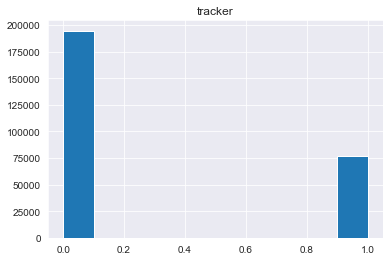

In [32]:
train_data[['tracker']].hist()

In [69]:
def split_dataset(splitter, X, y):
    for train, test in splitter.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

    return X_train, y_train, X_test, y_test


def stratified_shuffle_split(X, y):
    split = StratifiedShuffleSplit(n_splits=1, random_state=100, test_size=0.7)
    return split_dataset(split, X, y)

X_train_2, y_train_2, X_test_2, y_test_2 = stratified_shuffle_split(
            train_data.iloc[:, :-1], train_data[["tracker"]]
        )

In [70]:
X_train_2

,content-type,accept-ranges,etag,vary,content-encoding,cache-control,expires,content-length,server,age,...,x-cdn-pop-ip_binary,etag_length,access-control-allow-origin_cumulative,pragma_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,strict-transport-security_binary,access-control-allow-credentials_binary,timing-allow-origin_binary
101162,image/jpeg,bytes,dot:5b232a87-42fd-45cc-bbf3-6ca205ba2972:16356...,accept-encoding,gzip,"public, max-age=31536000","sat, 12 aug 2023 09:36:12 gmt",52197,apache,90752.0,...,0,60,Missing,0,0,1,1,1,1,0
108956,image/gif,Missing,Missing,accept-encoding,gzip,"no-cache, no-store, must-revalidate","fri, 01 jan 1990 00:00:00 gmt",43,nginx,-1.0,...,0,-1,Missing,0,0,0,0,1,0,0
223650,image/png,bytes,"""595827d04e966678d7df6b3bd6a67b95""",accept-encoding,gzip,max-age=31536000,"thu, 31 dec 2037 23:55:55 gmt",1279,tengine,1997426.0,...,0,34,*,0,0,0,0,0,0,1
110859,text/html; charset=utf-8,bytes,0x8da7b64a03a8ae5,accept-encoding,gzip,max-age=3600,"thu, 31 dec 2037 23:55:55 gmt",7461,cloudflare,90752.0,...,0,-1,Missing,0,0,0,1,0,0,0
83135,text/css,bytes,"""622aeb19-13abe""",accept-encoding,gzip,"public, max-age=2592000","sun, 11 sep 2022 09:32:47 gmt",7461,Other,2209982.0,...,0,16,Missing,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248644,text/javascript,bytes,Missing,accept-encoding,br,"public, max-age=31536000","sat, 12 aug 2023 10:41:00 gmt",14301,sffe,3633.0,...,0,-1,Missing,0,0,1,1,0,0,0
122432,application/json,Missing,Missing,accept-encoding,gzip,"no-cache, no-store, max-age=0, must-revalidate","wed, 17 sep 1975 21:32:10 gmt",377,nginx,-1.0,...,0,-1,Other,1,1,0,0,0,1,0
26429,text/css; charset=utf-8,bytes,"""84155-/az0nzm9sn75zu5xnrc0ndz9k9q""","fastly-ssl, accept-encoding",gzip,max-age=31622400,"thu, 31 dec 2037 23:55:55 gmt",65317,nginx,42532.0,...,0,35,Missing,0,0,1,1,1,0,0
101429,application/javascript,bytes,"""6f6580be945e0877450aa19982696b68""",accept-encoding,gzip,max-age=31522853,"thu, 31 dec 2037 23:55:55 gmt",31929,amazons3,90752.0,...,0,34,*,0,0,0,0,0,0,0


In [67]:
def check_distribution(dataset, feature):
    values = dataset[dataset[feature].notnull()][feature]
    sample_size = {5001: 1067, 5000: 880, 2500: 748, 1000: 516, 500: 341, 200: 169}
    sample_values = [v for v in sample_size.keys() if len(values) > v]
    if len(sample_values) == 0:
        n = int(len(values) * 0.1)
    else:
        n = sample_size[sample_values[0]]
    feature_values = values.sample(n=n, random_state=10).to_numpy().astype(np.int64)
    stat, p_value = shapiro(feature_values)  # kstest(feature_values, 'norm')
    return stat, p_value

In [24]:
X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]
X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

In [237]:
correlation = train_data.corr().abs()

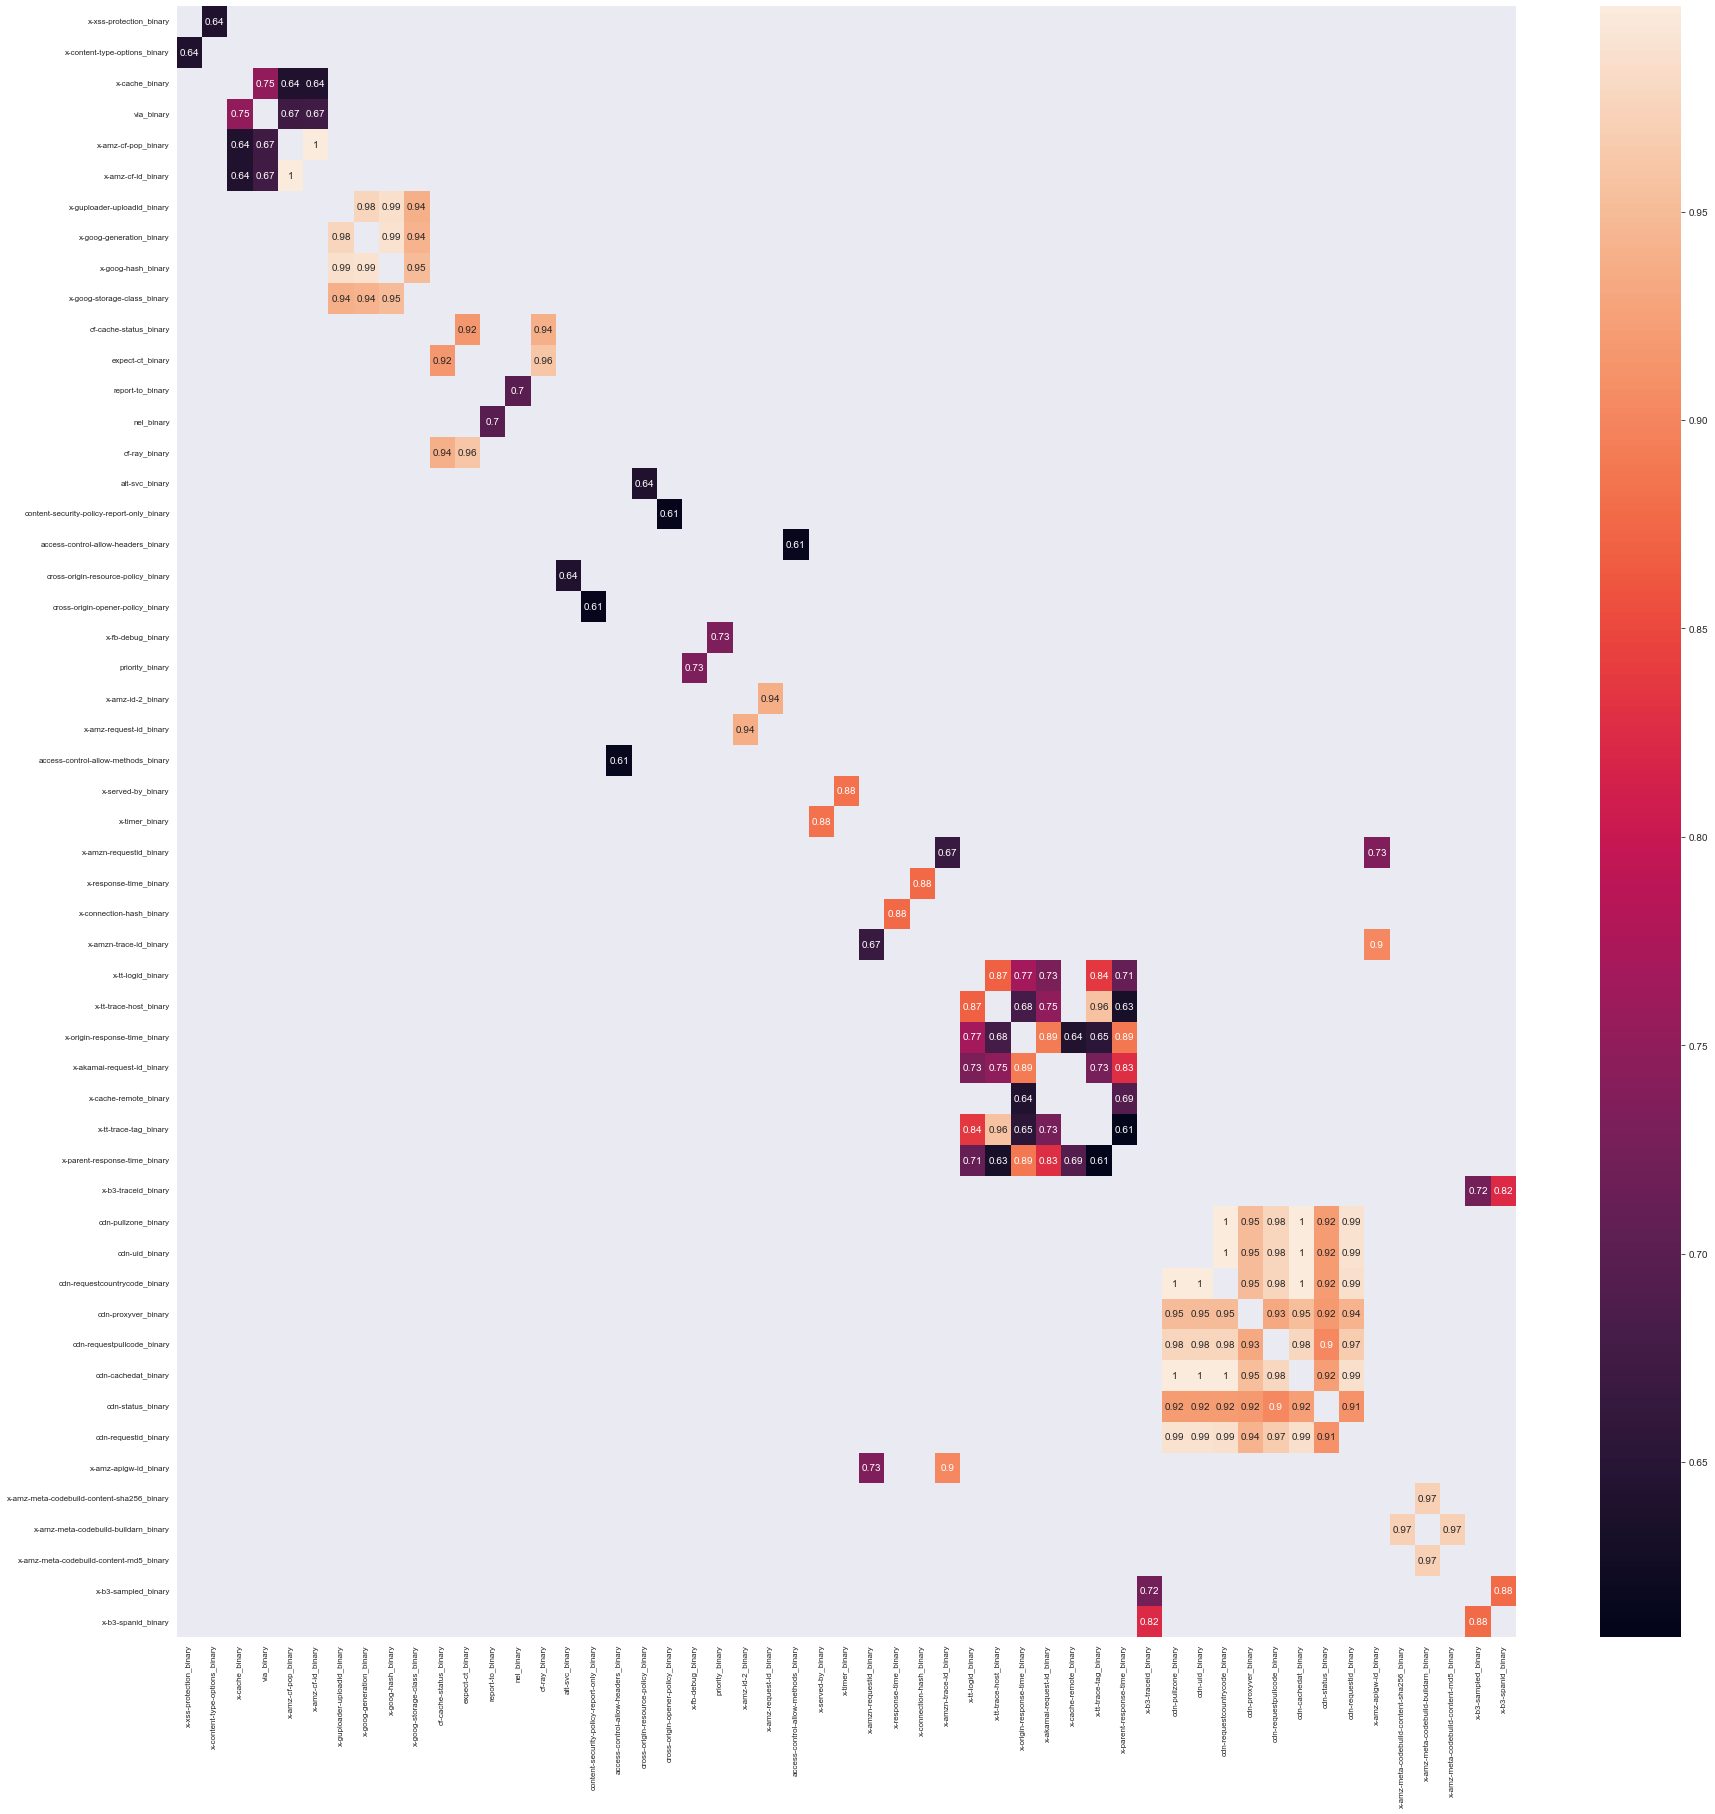

In [238]:
plt.figure(figsize=(30, 30))
sns.heatmap(
    correlation[(correlation > 0.6) & (correlation < 1.0)]
    .dropna(axis=0, how="all")
    .dropna(axis=1, how="all"),
    annot=True,
)
plt.xticks(rotation=90)
plt.yticks(rotation=360)
plt.tick_params(labelsize=8)
plt.show()

In [18]:
train_data.corr()["tracker"][:].abs()

content-length                             0.034346
age                                        0.133733
header_count                               0.302343
comb_col_non_tracker                       0.343886
comb_col_tracker                           0.190314
                                             ...   
x-content-type-options_binary              0.064524
strict-transport-security_binary           0.082633
access-control-allow-credentials_binary    0.254065
timing-allow-origin_binary                 0.090234
tracker                                    1.000000
Name: tracker, Length: 142, dtype: float64

In [20]:
data_copy_corr = train_data.copy(deep=True)

In [ ]:
# data_copy_corr.etag.replace(to_replace=r'\"', value="", regex=True)

In [27]:
for elem in data_copy_corr.columns.values:
    if data_copy_corr[elem].dtype == "category":
        data_copy_corr[elem] = data_copy_corr[elem].cat.codes

In [32]:
correlation_cat = data_copy_corr.corr()["tracker"][:].abs()

In [36]:
correlation_cat[correlation_cat > 0.6]

accept-ranges                   0.863473
expires                         0.692957
alt-svc                         0.793744
cross-origin-resource-policy    0.890408
tracker                         1.000000
Name: tracker, dtype: float64

In [29]:
%%time
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=10)
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_train, y_train)

CPU times: user 17.7 ms, sys: 750 µs, total: 18.4 ms
Wall time: 17.5 ms


0.7157431508360171

<AxesSubplot:>

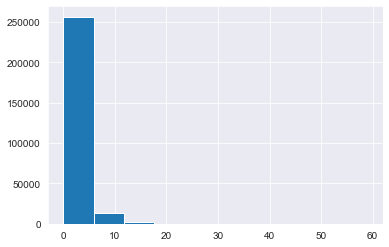

In [71]:
X_train['comb_col_non_tracker'].hist()

In [69]:
print(check_distribution(X_train, 'header_count'))

(0.9880671501159668, 1.2468900933981786e-07)


In [6]:
numeric_transformer = Pipeline(steps=[("scaler", FunctionTransformer(np.log1p))])
# binary_encoder = Pipeline(steps=[("label_enc", LabelEncoder())])
minmax_transformer = Pipeline(steps=[("mmscaler", MinMaxScaler(feature_range=[-1,1]))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, ['content-length']),
        ('age', minmax_transformer, ['age']),
        # ("bin", binary_encoder, ['connection_binary', 'via_binary']), # selector(pattern=r".*_binary")
        ("cat", ce.WOEEncoder(), selector(dtype_include="category")),
    ]
)

In [30]:
# cat_model = CatBoostClassifier(thread_count=-1)
rf_model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=10,
    criterion="log_loss",
    max_features=None,
)

# dt_model = DecisionTreeClassifier(
#     criterion="log_loss", random_state=10, class_weight="balanced"
# )

In [87]:
log_model = LogisticRegression(n_jobs=-1, random_state=10)

In [ ]:
# clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5)
#
# trans = BorutaPy(clf, random_state=42, verbose=2)
# sel = trans.fit_transform(X_train.values, y_train.values)

In [ ]:
# sel = SelectFromModel(RandomForestClassifier(n_estimators=100))

In [8]:
clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", rf_model)])

In [19]:
clf.fit(X_train, y_train["tracker"].to_numpy())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['content-length']),
                                                 ('age',
                                                  Pipeline(steps=[('mmscaler',
                                                                   MinMaxScaler(feature_range=[-1,
                                                                                               1]))]),
                                                  ['age']),
                                                 ('cat', WOEEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd2043f0970>)])),
                ('classifier',
                 RandomForestClassifier(criterion='log_loss', max_features=None,
                                        n_jobs=-1, random_state=10))])

In [31]:
rf_model.fit(X_train, y_train["tracker"].to_numpy())

RandomForestClassifier(criterion='log_loss', max_features=None, n_jobs=-1,
                       random_state=10)

In [20]:
y_pred = clf.predict(X_test)
print("Model accuracy score : {0:0.4f}".format(metrics.accuracy_score(y_test, y_pred)))
clf_probs = clf.predict_proba(X_test)
score = metrics.log_loss(y_test, clf_probs)
print("Model log-loss score : {0:0.4f}".format(score))

Model accuracy score : 0.9983
Model log-loss score : 0.0111


In [32]:
y_pred_2 = rf_model.predict(X_test)
print("Model accuracy score : {0:0.4f}".format(metrics.accuracy_score(y_test, y_pred_2)))
clf_probs_2 = rf_model.predict_proba(X_test)
score_2 = metrics.log_loss(y_test, clf_probs_2)
print("Model log-loss score : {0:0.4f}".format(score_2))

Model accuracy score : 0.9346
Model log-loss score : 0.3680


In [75]:
comparison = pd.DataFrame(np.column_stack((y_test, y_pred)), columns=['test', 'pred'])

In [76]:
comparison[comparison.test != comparison.pred]

,test,pred
1958,0,1
4087,0,1
4384,0,1
11092,1,0
15579,1,0
19827,1,0
20999,1,0
25380,1,0
27987,1,0
31083,1,0


In [77]:
X_test.iloc[15790, :]

content-type                                                        image/png
accept-ranges                                                           bytes
etag                                       "03d0d929cb9cfa2727ad275070ea60ff"
vary                                                          accept-encoding
content-encoding                                                         gzip
                                                          ...                
x-xss-protection_binary                                                     0
x-content-type-options_binary                                               0
strict-transport-security_binary                                            0
access-control-allow-credentials_binary                                     0
timing-allow-origin_binary                                                  0
Name: 19827, Length: 152, dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'header_count'),
  Text(1, 0, 'comb_col_non_tracker'),
  Text(2, 0, 'comb_col_tracker'),
  Text(3, 0, 'pragma_binary'),
  Text(4, 0, 'content-type_binary'),
  Text(5, 0, 'last-modified_binary'),
  Text(6, 0, 'accept-ranges_binary'),
  Text(7, 0, 'etag_binary'),
  Text(8, 0, 'p3p_binary'),
  Text(9, 0, 'x-xss-protection_binary'),
  Text(10, 0, 'x-content-type-options_binary'),
  Text(11, 0, 'strict-transport-security_binary'),
  Text(12, 0, 'x-robots-tag_binary'),
  Text(13, 0, 'vary_binary'),
  Text(14, 0, 'content-encoding_binary'),
  Text(15, 0, 'cache-control_binary'),
  Text(16, 0, 'expires_binary'),
  Text(17, 0, 'date_binary'),
  Text(18, 0, 'content-length_binary'),
  Text(19, 0, 'connection_binary'),
  Text(20, 0, 'x-amz-server-side-encryption_binary'),
  Text(21, 0, 'x-amz-version-id_binary'),
  Text(22, 0, 'server_b

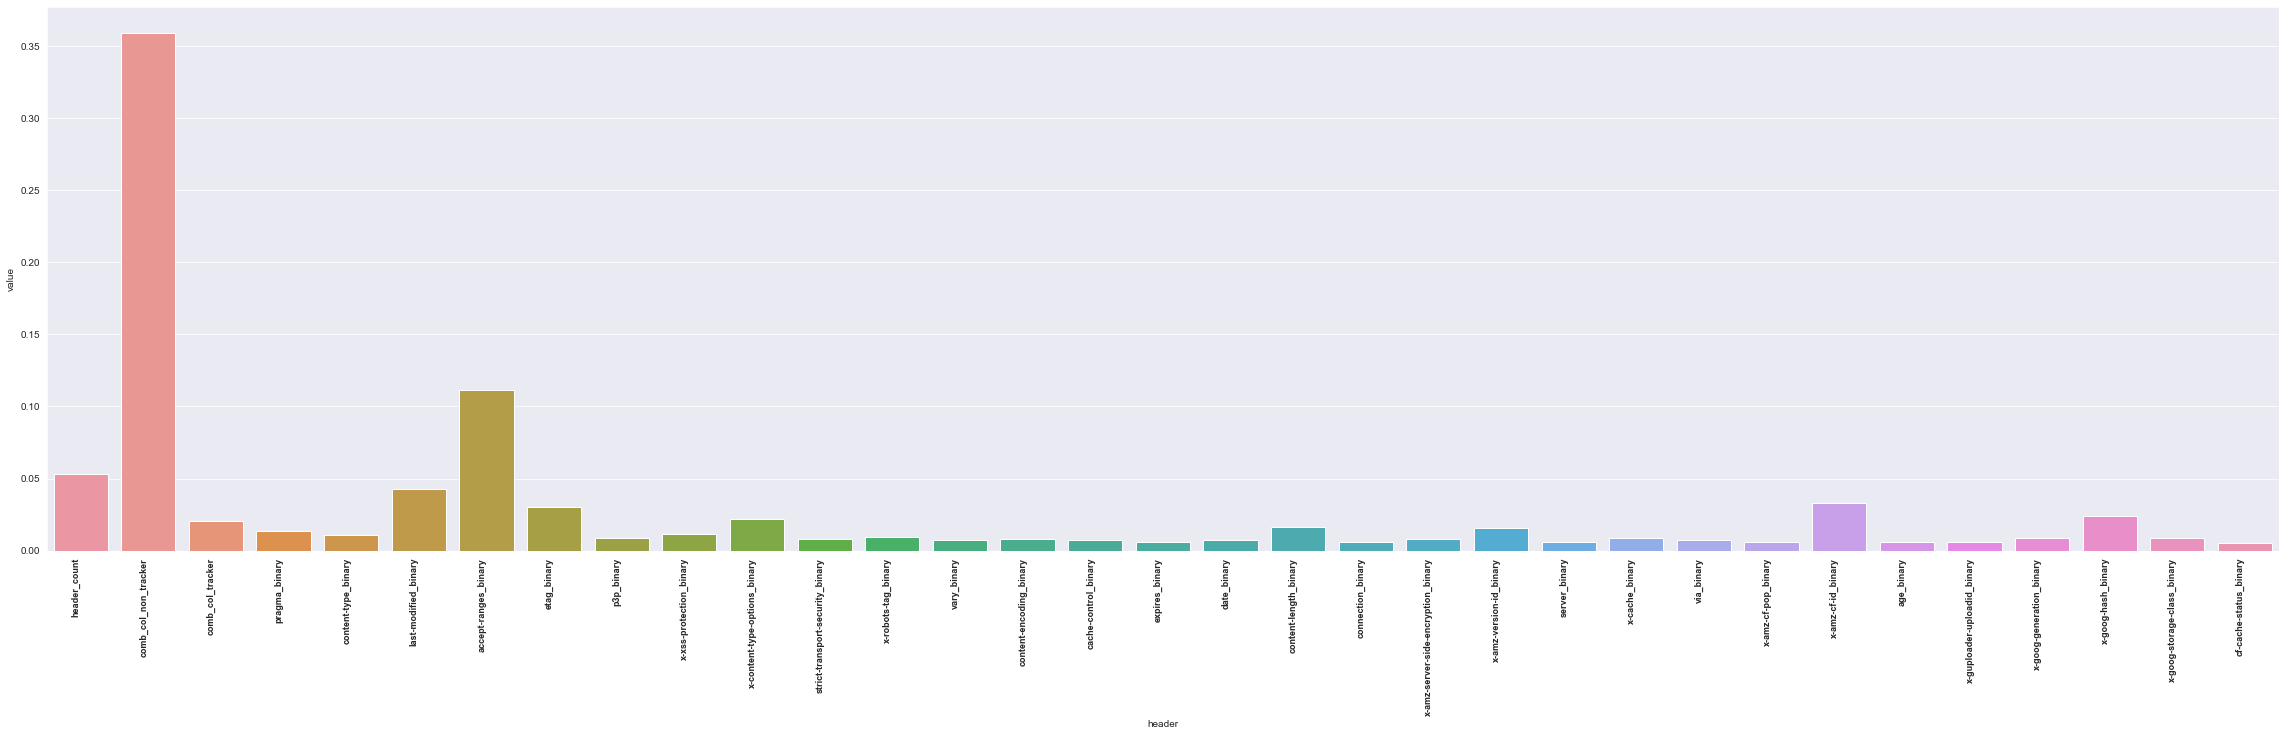

In [296]:
# pd.DataFrame(rf_model.feature_importances_, index=X_train.columns.values).plot()

importance = rf_model.feature_importances_
importance = importance[np.where(importance > 0.005)]
d = {"header": X_train.columns.values[np.where(importance > 0.005)], "value": importance.tolist()}
plt.figure(figsize=(40, 10))
sns.barplot(data=pd.DataFrame(d), x="header", y="value")
plt.xticks(rotation=90, fontsize=9, fontweight="bold", ha="right")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 [Text(0, 0, 'comb_col_non_tracker'),
  Text(1, 0, 'comb_col_tracker'),
  Text(2, 0, 'pragma_binary'),
  Text(3, 0, 'content-type_binary'),
  Text(4, 0, 'last-modified_binary'),
  Text(5, 0, 'accept-ranges_binary'),
  Text(6, 0, 'etag_binary'),
  Text(7, 0, 'p3p_binary'),
  Text(8, 0, 'x-xss-protection_binary'),
  Text(9, 0, 'x-content-type-options_binary'),
  Text(10, 0, 'strict-transport-security_binary'),
  Text(11, 0, 'x-robots-tag_binary'),
  Text(12, 0, 'vary_binary'),
  Text(13, 0, 'content-encoding_binary'),
  Text(14, 0, 'cache-control_binary'),
  Text(15, 0, 'expires_binary'),
  Text(16, 0, 'date_binary'),
  Text(17, 0, 'content-length_binary'),
  Text(18, 0, 'connection_binary'),
  Text(19, 0, 'x-amz-server-side-encryption_binary'),
  Text(20, 0, 'x-amz-version-id_binary'),
  Text(21, 0, 'server_binary'),
  

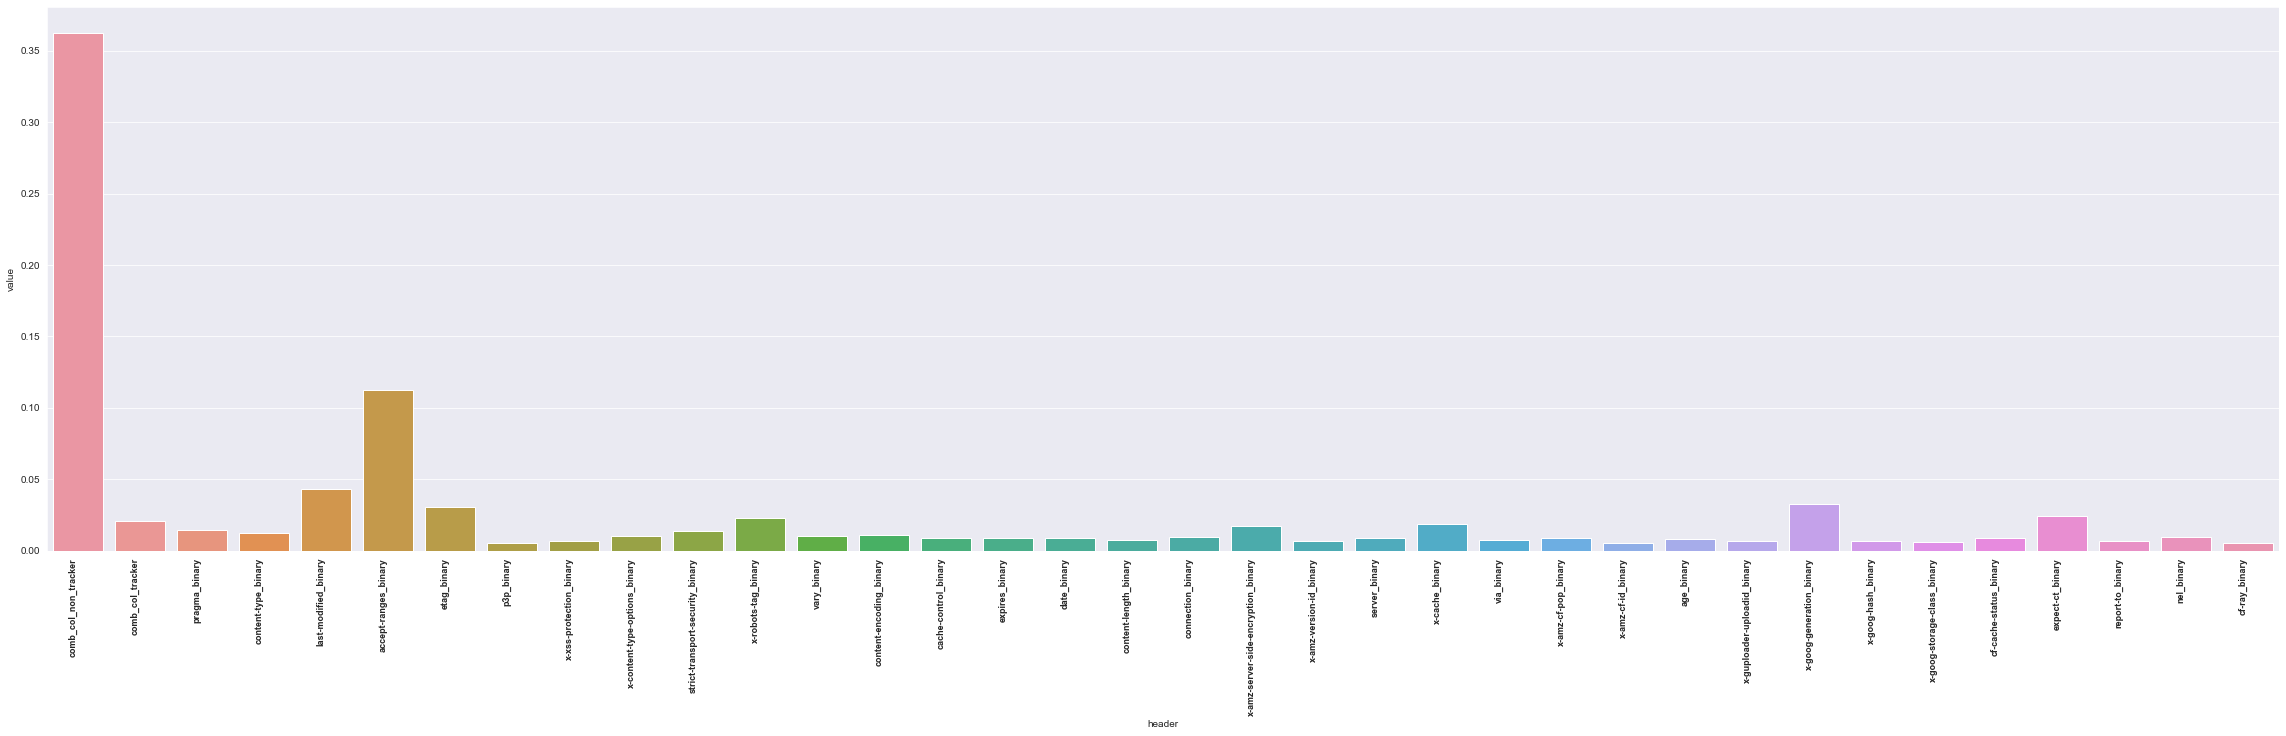

In [49]:
# pd.DataFrame(rf_model.feature_importances_, index=X_train.columns.values).plot()

importance = rf_model.feature_importances_
importance = importance[np.where(importance > 0.005)]
d = {"header": X_train.columns.values[np.where(importance > 0.005)], "value": importance.tolist()}
plt.figure(figsize=(40, 10))
sns.barplot(data=pd.DataFrame(d), x="header", y="value")
plt.xticks(rotation=90, fontsize=9, fontweight="bold", ha="right")

In [299]:
train_data[['comb_col_non_tracker', 'comb_col_tracker', 'tracker']]

,comb_col_non_tracker,comb_col_tracker,tracker
0,0,0,1
1,2,0,0
2,0,0,1
3,1,0,0
4,1,0,0
...,...,...,...
271999,5,0,0
272000,0,0,1
272001,0,0,0
272002,2,0,0


In [295]:
X_train.columns.values[np.where(importance > 0.005)]

array(['header_count', 'comb_col_non_tracker', 'comb_col_tracker',
       'pragma_binary', 'last-modified_binary', 'accept-ranges_binary',
       'etag_binary', 'p3p_binary', 'strict-transport-security_binary',
       'vary_binary', 'content-encoding_binary', 'cache-control_binary',
       'expires_binary', 'content-length_binary', 'connection_binary',
       'server_binary', 'via_binary', 'age_binary', 'report-to_binary',
       'alt-svc_binary', 'access-control-allow-credentials_binary',
       'access-control-allow-origin_binary', 'set-cookie_binary',
       'content-security-policy-report-only_binary',
       'access-control-allow-headers_binary',
       'access-control-max-age_binary',
       'cross-origin-resource-policy_binary',
       'content-security-policy_binary',
       'cross-origin-opener-policy_binary', 'x-frame-options_binary',
       'timing-allow-origin_binary', 'x-served-by_binary', 'x-cdn_binary'],
      dtype=object)

In [291]:
np.where(importance > 0.005)

(array([ 0,  1,  2,  3,  5,  6,  7,  8, 11, 13, 14, 15, 16, 18, 19, 22, 24,
        27, 34, 37, 38, 39, 40, 41, 43, 44, 46, 48, 49, 50, 53, 57, 99]),)

In [292]:
importance[np.where(importance > 0.005)]

array([0.05335931, 0.3589723 , 0.02062972, 0.01365111, 0.01120562,
       0.04244821, 0.1113891 , 0.02999851, 0.00872753, 0.01166495,
       0.02170855, 0.00823341, 0.00927785, 0.00717272, 0.00801258,
       0.00721986, 0.00597905, 0.00724657, 0.01610535, 0.00630692,
       0.00792408, 0.01595787, 0.00621438, 0.00895014, 0.0071888 ,
       0.00586557, 0.03273948, 0.00616777, 0.00610349, 0.00878977,
       0.02390799, 0.00895316, 0.00513882])

In [101]:
clf["classifier"].ranking_

AttributeError: 'RandomForestClassifier' object has no attribute 'ranking_'

In [53]:
fs = SelectKBest(score_func=chi2, k="all")
# fs.fit(X_train[identify_nominal_columns(X_train)], y_train)

In [58]:
clf = Pipeline(steps=[("preprocessor", preprocessor), ("feature_selection", fs)])
clf.fit(X_train, y_train["tracker"].to_numpy())

ValueError: Input X must be non-negative.

In [102]:
X_train.columns[0:12][(clf["classifier"].get_support())]

AttributeError: 'RandomForestClassifier' object has no attribute 'get_support'

In [78]:
clf.score(X_test, y_test)

0.9991470713665975

In [79]:
clf.score(X_train, y_train)

0.9998125

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [80, 90, 100, 110],
    "max_features": [2, 3],
    "min_samples_leaf": [3, 4, 5],
    "min_samples_split": [8, 10, 12],
    "n_estimators": [100, 200, 300, 1000],
}
grid_search = GridSearchCV(rf_model, param_grid=param_grid, cv=3, n_jobs=-1)

In [60]:
y_pred_3 = rf_model.predict(X_test)
print("Model accuracy score : {0:0.4f}".format(metrics.accuracy_score(y_test, y_pred_3)))

Model accuracy score : 0.9347


In [29]:
clf_probs = clf.predict_proba(X_test)
score = metrics.log_loss(y_test, clf_probs)
print("Model log-loss score : {0:0.4f}".format(score))

Model log-loss score : 0.0111


In [68]:
a = rf_model.decision_path(X_test)

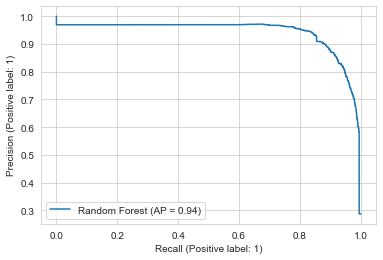

In [74]:
display = metrics.PrecisionRecallDisplay.from_estimator(
    rf_model, X_test, y_test, name="Random Forest"
)

In [52]:
metrics.roc_auc_score(y_test, y_pred_2)

0.9276401476789599

In [205]:
X_train.columns.values

array(['content-type', 'accept-ranges', 'etag', 'vary',
       'content-encoding', 'cache-control', 'expires', 'content-length',
       'server', 'age', 'alt-svc', 'cross-origin-resource-policy',
       'header_count', 'comb_col_non_tracker', 'comb_col_tracker',
       'x-robots-tag_binary', 'connection_binary',
       'x-amz-server-side-encryption_binary', 'x-amz-version-id_binary',
       'x-cache_binary', 'via_binary', 'x-amz-cf-pop_binary',
       'x-amz-cf-id_binary', 'x-guploader-uploadid_binary',
       'x-goog-generation_binary', 'x-goog-hash_binary',
       'x-goog-storage-class_binary', 'cf-cache-status_binary',
       'expect-ct_binary', 'report-to_binary', 'nel_binary',
       'cf-ray_binary', 'set-cookie_binary',
       'content-security-policy-report-only_binary',
       'access-control-expose-headers_binary',
       'access-control-allow-headers_binary',
       'access-control-max-age_binary', 'x-powered-by_binary',
       'cross-origin-opener-policy-report-only_binary',

In [22]:
clf['classifier'].feature_importances_

array([1.86188389e-04, 1.17594369e-03, 2.80934584e-04, 2.07835993e-03,
       8.94268288e-01, 1.12665170e-03, 1.42432403e-05, 2.51072118e-04,
       1.62195743e-02, 4.50248553e-04, 2.72013244e-03, 8.11768028e-02,
       5.15602823e-05])

In [82]:
X_train_2

,content-type,accept-ranges,etag,vary,content-encoding,cache-control,expires,content-length,server,age,...,x-cdn-pop-ip_binary,etag_length,access-control-allow-origin_cumulative,pragma_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,strict-transport-security_binary,access-control-allow-credentials_binary,timing-allow-origin_binary
101162,image/jpeg,bytes,dot:5b232a87-42fd-45cc-bbf3-6ca205ba2972:16356...,accept-encoding,gzip,"public, max-age=31536000","sat, 12 aug 2023 09:36:12 gmt",52197,apache,90752.0,...,0,60,Missing,0,0,1,1,1,1,0
108956,image/gif,Missing,Missing,accept-encoding,gzip,"no-cache, no-store, must-revalidate","fri, 01 jan 1990 00:00:00 gmt",43,nginx,-1.0,...,0,-1,Missing,0,0,0,0,1,0,0
223650,image/png,bytes,"""595827d04e966678d7df6b3bd6a67b95""",accept-encoding,gzip,max-age=31536000,"thu, 31 dec 2037 23:55:55 gmt",1279,tengine,1997426.0,...,0,34,*,0,0,0,0,0,0,1
110859,text/html; charset=utf-8,bytes,0x8da7b64a03a8ae5,accept-encoding,gzip,max-age=3600,"thu, 31 dec 2037 23:55:55 gmt",7461,cloudflare,90752.0,...,0,-1,Missing,0,0,0,1,0,0,0
83135,text/css,bytes,"""622aeb19-13abe""",accept-encoding,gzip,"public, max-age=2592000","sun, 11 sep 2022 09:32:47 gmt",7461,Other,2209982.0,...,0,16,Missing,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248644,text/javascript,bytes,Missing,accept-encoding,br,"public, max-age=31536000","sat, 12 aug 2023 10:41:00 gmt",14301,sffe,3633.0,...,0,-1,Missing,0,0,1,1,0,0,0
122432,application/json,Missing,Missing,accept-encoding,gzip,"no-cache, no-store, max-age=0, must-revalidate","wed, 17 sep 1975 21:32:10 gmt",377,nginx,-1.0,...,0,-1,Other,1,1,0,0,0,1,0
26429,text/css; charset=utf-8,bytes,"""84155-/az0nzm9sn75zu5xnrc0ndz9k9q""","fastly-ssl, accept-encoding",gzip,max-age=31622400,"thu, 31 dec 2037 23:55:55 gmt",65317,nginx,42532.0,...,0,35,Missing,0,0,1,1,1,0,0
101429,application/javascript,bytes,"""6f6580be945e0877450aa19982696b68""",accept-encoding,gzip,max-age=31522853,"thu, 31 dec 2037 23:55:55 gmt",31929,amazons3,90752.0,...,0,34,*,0,0,0,0,0,0,0


In [23]:
random_forest_feature_importance(clf['classifier'], X_train.columns.values)

[(0.8943, 'content-encoding'),
 (0.0812, 'cross-origin-resource-policy'),
 (0.0162, 'server'),
 (0.0027, 'alt-svc'),
 (0.0021, 'vary'),
 (0.0012, 'accept-ranges'),
 (0.0011, 'cache-control'),
 (0.0005, 'age'),
 (0.0003, 'etag'),
 (0.0003, 'content-length'),
 (0.0002, 'content-type'),
 (0.0001, 'comb_col_non_tracker'),
 (0.0, 'expires')]

In [25]:
f1_score = metrics.f1_score(y_test, y_pred)
bal_acc = metrics.balanced_accuracy_score(y_test, y_pred)

print("Balanced accuracy score : {0:0.4f}".format(bal_acc))
print("F1 score : {0:0.4f}".format(f1_score))

Balanced accuracy score : 0.9981
F1 score : 0.9970


In [24]:
metrics.precision_score(y_test, y_pred)

0.9963765843733233

In [53]:
f1_score = metrics.f1_score(y_test, y_pred_2)
bal_acc = metrics.balanced_accuracy_score(y_test, y_pred_2)
precision = metrics.precision_score(y_test, y_pred_2)

print("Balanced accuracy score : {0:0.4f}".format(bal_acc))
print("F1 score : {0:0.4f}".format(f1_score))
print("Precision score : {0:0.4f}".format(precision))

Balanced accuracy score : 0.9276
F1 score : 0.8892
Precision score : 0.8683


In [54]:
print(metrics.classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95    355043
           1       0.87      0.91      0.89    143325

    accuracy                           0.93    498368
   macro avg       0.92      0.93      0.92    498368
weighted avg       0.94      0.93      0.94    498368



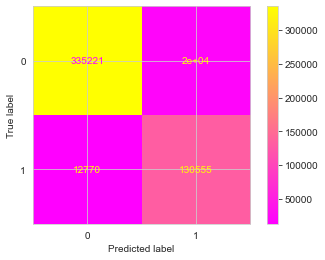

In [33]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2, cmap="spring")
# TN FP
# FN TP

In [ ]:
fig = plt.figure(figsize=(60, 60))
_ = tree.plot_tree(
    clf["classifier"],
    feature_names=X_train.columns,
    # class_names=iris.target_names,
    filled=True,
    fontsize=11,
)

In [166]:
%%time
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(
    clf, X_train, y_train, scoring="accuracy", cv=cv, n_jobs=-1, error_score="raise"
)
# report pipeline performance
print("Accuracy: %.3f (%.3f)" % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 1.000 (0.000)
CPU times: user 836 ms, sys: 618 ms, total: 1.45 s
Wall time: 18.4 s


In [35]:
importance = rf_model.feature_importances_
# d = {"header": X_train.columns.values.tolist(), "value": importance.tolist()}

In [38]:
pd.DataFrame(importance, index=X_train.columns.values.tolist())

,0
comb_col_non_tracker,0.362457
comb_col_tracker,0.020470
pragma_binary,0.014810
content-type_binary,0.003616
last-modified_binary,0.012478
...,...
x-b3-spanid_binary,0.000027
x-hubspot-correlation-id_binary,0.000091
x-hs-target-asset_binary,0.000531
x-hostname_binary,0.000019


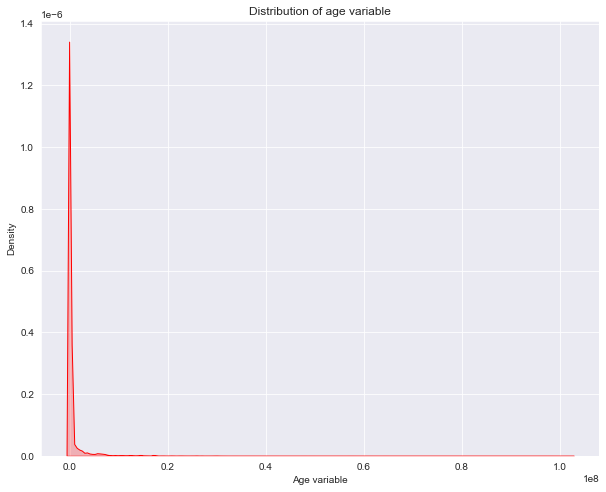

In [107]:
f, ax = plt.subplots(figsize=(10, 8))
x = X_train["age"]
x = pd.Series(x, name="Age variable")
ax = sns.kdeplot(x, shade=True, color="red")
ax.set_title("Distribution of age variable")
plt.show()

In [40]:
fpr, tpr, _ = metrics.roc_curve(y_test, clf_probs_2[:,1])

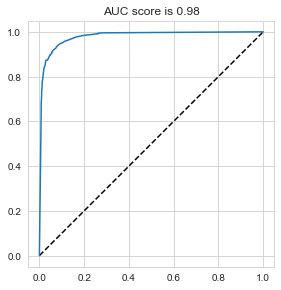

In [41]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(metrics.roc_auc_score(y_test, clf_probs_2[:,1])))
ax.set_aspect(1)

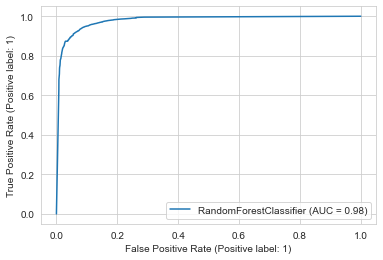

In [45]:
metrics.RocCurveDisplay.from_estimator(rf_model, X_test, y_test)

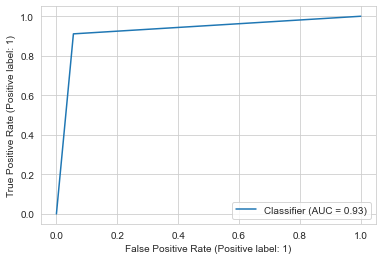

In [47]:
metrics.RocCurveDisplay.from_predictions(y_test, y_pred_2)

In [56]:
train_data[['age', 'tracker']].value_counts()

age           tracker
 90752.0      0          93593
-1.0          1          62554
 1.0          0           3855
 0.0          0           1556
              1            694
                         ...  
 107617.0     0              1
 107622.0     0              1
 107623.0     0              1
 107630.0     0              1
 102234524.0  0              1
Length: 64593, dtype: int64

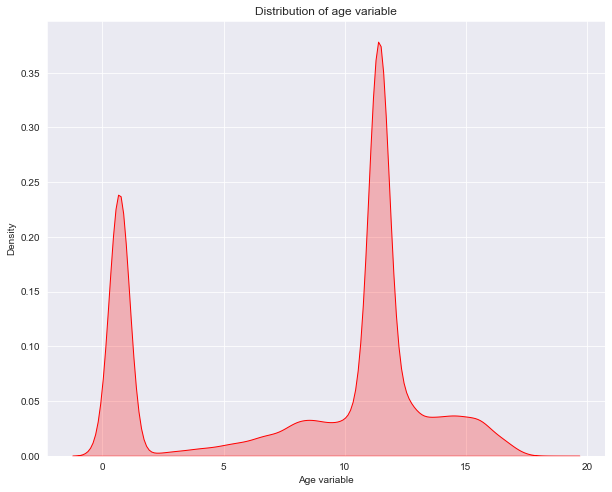

In [73]:
f, ax = plt.subplots(figsize=(10, 8))
x = np.log1p(train_data.age.abs())
x = pd.Series(x, name="Age variable")
ax = sns.kdeplot(x, shade=True, color="red")
ax.set_title("Distribution of age variable")
plt.show()

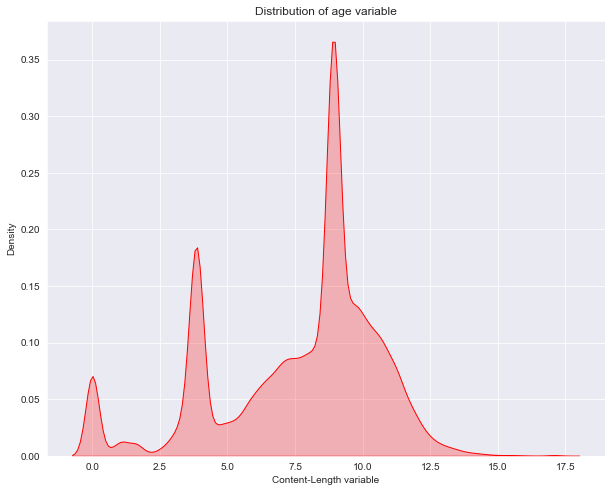

In [123]:
f, ax = plt.subplots(figsize=(10, 8))
x = np.log1p(train_data['content-length'])
x = pd.Series(x, name="Content-Length variable")
ax = sns.kdeplot(x, shade=True, color="red")
ax.set_title("Distribution of age variable")
plt.show()

Text(0, 0.5, 'Count')

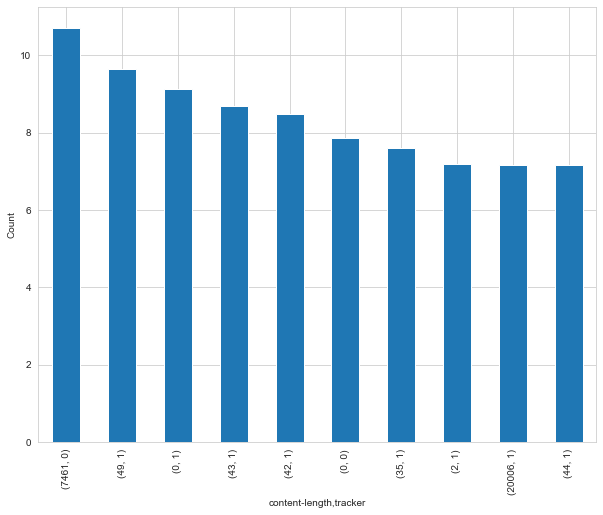

In [152]:
np.log1p(train_data[['content-length', 'tracker']].value_counts()[0:10]).plot(kind='bar', figsize=(10, 8))
plt.ylabel('Count')

Text(0, 0.5, 'Count')

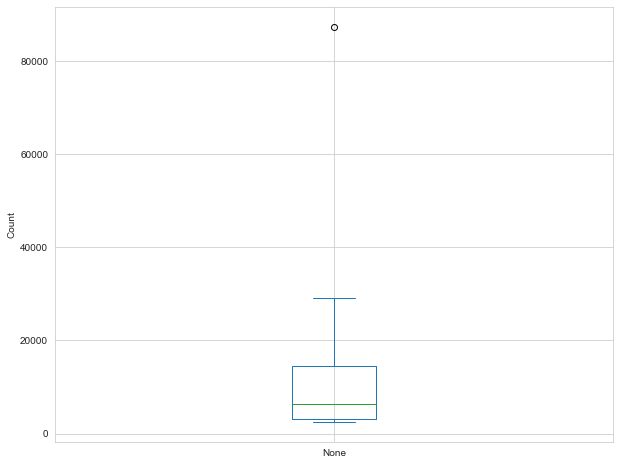

In [155]:
test_data[['content-length', 'tracker']].value_counts()[0:10].plot(kind='box', figsize=(10, 8))
plt.ylabel('Count')

In [125]:
test_data[['content-encoding', 'tracker']].value_counts()

content-encoding  tracker
gzip              0          301378
                  1          126220
br                0           49793
                  1           16722
identity          0            3802
                  1             317
deflate           0              34
                  1              32
none              1              31
utf-8             0              15
base64            0               9
utf8              0               5
none              0               3
utf-8             1               3
text              0               2
iso-8859-1        0               1
application/json  0               1
dtype: int64

<AxesSubplot:xlabel='content-length'>

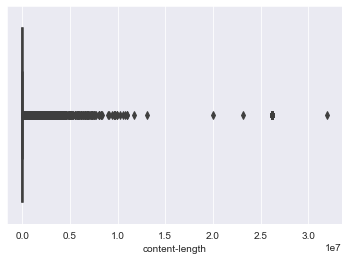

In [91]:
sns.boxplot(data=train_data, x='content-length')

In [147]:
feature = 'comb_col_non_tracker'
df = pd.DataFrame({
    feature:np.concatenate((train_data.loc[:,feature],test_data.loc[:,feature])),
    'set':['training']*train_data.shape[0] + ['test']*test_data.shape[0]
    })

<AxesSubplot:xlabel='comb_col_non_tracker', ylabel='Proportion'>

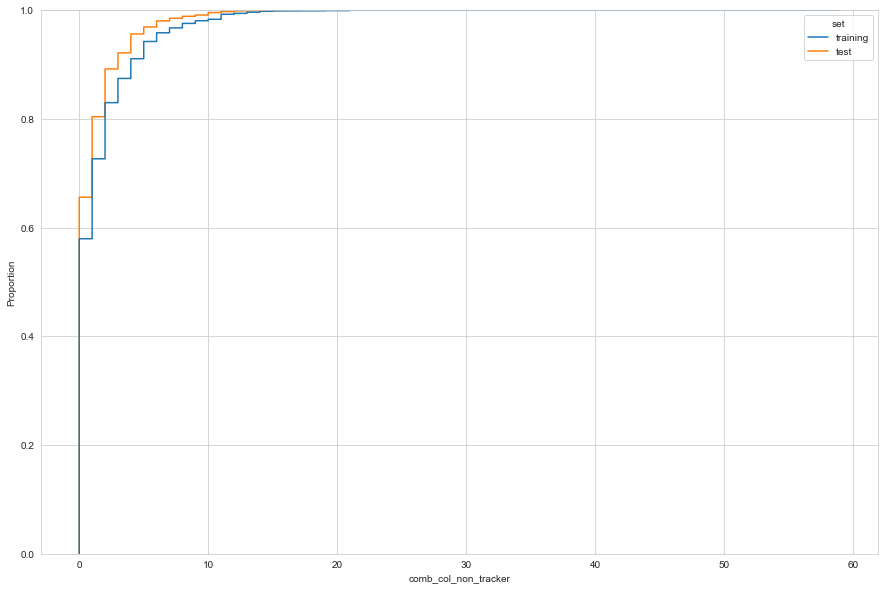

In [150]:
plt.figure(figsize=(15, 10))
sns.ecdfplot(data=df, x=feature, hue='set', log_scale=False)

In [149]:
# check distance between train and test data, max distance between features
ks_2samp(train_data.loc[:,feature],test_data.loc[:,feature]).statistic

0.07752706061979997

In [146]:
train_data.dtypes

content-type                               category
accept-ranges                              category
etag                                       category
vary                                       category
content-encoding                           category
                                             ...   
x-content-type-options_binary                 int64
strict-transport-security_binary              int64
access-control-allow-credentials_binary       int64
timing-allow-origin_binary                    int64
tracker                                       uint8
Length: 153, dtype: object